This Code will give a basin of attraction for a specified ODE system, it can have up to 3 variables. If the Fixed Point attractor is known set FP to the this attractor. If this is unknown, use the eqm solving function to find eqm points.
//
This programme uses Parallel Processing to compute the basin. 

In [1]:
import numpy as np
from scipy.optimize import root
import scipy.integrate as si
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches
import matplotlib.colors as colors
from joblib import Parallel, delayed
import itertools as it


In [37]:
#PARAMETERS OF THE SYSTEM
epsilon = 0.2 #error NEEDS TO BE VARIABLE
eta = 10  #fixed parameter of system
alpha = np.pi / 2  #average phase difference of system
kappa = 0 #coupling factor
omega = [-3,-4,-5] #array of frequencies
N = len(omega) #number of oscillators
args = (omega, kappa, eta, epsilon, alpha,N) # if any args are added/removed update here


#PARAMETERS FOR THIS PROGRAMME
threshold = 1e-1 #
grid_size = 3 #grid_size X grid_size set of initial conditions for Basin of Attraction
y0_range = np.linspace(-5,12,grid_size) #range for time dependent parameter
y1_range = np.linspace(0,2*np.pi,grid_size) #range for Osc. 1

size = 3 #How many vales the equilibrium system is evaulating for i.e. 3x3  

#TIME PARAMETERS
tf = 20000000 #end of eval
tspan = (0,tf)
te = 19999990 #starting evaluating from te
tlength = 1000  #the number of points being evaluated
t_eval = np.linspace(te,tf,tlength)

In [3]:
# Define the system of ODEs 
#this includes the time dependency of the system
def ode_N(t,y, omega, kappa, N, eta, epsilon, alpha):

    dydt = np.zeros(N + 1)

    for i in range(N):
        dydt[i + 1] = omega[i] + y[0] - np.sin(y[i + 1]) + (kappa / N) * sum(np.sin(y[j] - y[i]) for j in range(N))
    
    dydt[0] = epsilon * (-y[0] + eta - (eta / N) * sum(np.sin(y[j + 1] + alpha) for j in range(N)))
    return dydt

In [4]:
def equations(y, omega, kappa, N, eta, epsilon, alpha):

    dydt = np.zeros(N + 1)

    for i in range(N):
        dydt[i + 1] = omega[i] + y[0] - np.sin(y[i + 1]) + (kappa / N) * sum(np.sin(y[j] - y[i]) for j in range(N))
    
    dydt[0] = epsilon * (-y[0] + eta - (eta / N) * sum(np.sin(y[j + 1] + alpha) for j in range(N)))
    return dydt

In [5]:
#Solves system for Eqm points which should correlate to attractors but need to be checked
def equilibriumpoints(equations, N, omega, kappa, eta, epsilon, alpha,size):
    # Generate initial guesses
    mu0 = np.linspace(-30, 10, size)
    phi0 = np.linspace(0, 2 * np.pi, size)
    ICphi = list(it.product(phi0, repeat=N))  # Convert product iterator to list
    
    # Create all combinations of (mu, phi1, phi2, ..., phiN)
    Guesses = np.array([(mu, *phi) for phi in ICphi for mu in mu0])
    
    eqms = []  # Store equilibrium points
    
    # Solve for equilibrium points
    for i in range(Guesses.shape[0]):
        y0 = Guesses[i]
        eqm = root(equations, y0, args=(omega, kappa, N, eta, epsilon, alpha), method='lm')

        if eqm.success:  # Only store successful solutions
            mu = eqm.x[0]
            phi_values = [np.mod(eqm.x[j + 1], 2 * np.pi) for j in range(N)]
            eqms.append((mu, *phi_values))  # Append solution as tuple
    
    # Convert to NumPy array and get unique values
    eqms = np.array(eqms)
    eqms = np.round(eqms, 2)
    unique = np.unique(eqms, axis=0)
    
    return unique


In [6]:
def mod2pi(phi):
    phimod = []
    for i in phi:
        i = np.mod(i,2*np.pi)
        phimod = np.append(phimod,i)
    return phimod

In [7]:
size = 20

In [8]:
#FP = equilibriumpoints(equations, N, omega, kappa, eta, epsilon, alpha,size)  #Works for N>2

In [9]:
#FP

In [10]:
#Modulates the Oscillators such that the system oscillates between (0,2pi)
def mod2pi(phi):
    phimod = []
    for i in phi:
        i = np.mod(i,2*np.pi)
        phimod = np.append(phimod,i)
    return phimod

In [11]:
def plot_phi_v_mu(mu,phi_cleaned):
   
    plt.figure(figsize=(10, 6))
    for i in range(len(phi_cleaned)):
        plt.plot( mu ,phi_cleaned[i], label=f'Phi {i+1}') 
    plt.legend()
    plt.grid()
    plt.xlabel(r'$\mu(t)$')
    plt.ylabel(r'$\varphi_i(t)$')
    plt.title('Dynamics of the System')
    plt.show()

In [33]:
#Solves the system using solve_ivp function & modulates the trajectory of the oscillators with 2pi
def solve(y0):
    soln2 = si.solve_ivp(ode_N,tspan,y0,args = (omega, kappa, N, eta, epsilon, alpha),method = 'Radau',t_eval=t_eval)
    print(soln2.y)
    phi = []
    for i in range(N):
        p = mod2pi(soln2.y[i,:])
        phi.append(p) 
    mu = soln2.y[0,:]
    return mu,phi

In [ ]:
def classify_attractor(solution,threshold):
    state_final = solution.y[:, -1]  # Last state
    derivatives = np.array([ode_N(0, state_final, omega, kappa, N, eta, epsilon, alpha)])  

    # Fixed point check
    if np.linalg.norm(derivatives) < threshold: ##checking how close the system is to having 0 derivatives --> no change in the system => Fixed point
        return 1  # Fixed point
    
    # Periodic behavior check
    else:
        return 2

In [14]:
def compute_basin_point(y0_0, y1_0,FP,threshold):
    FP =  np.delete(FP,0) 
    initial_conditions = np.insert(FP,0,y0_0,)
    initial_conditions = np.delete(initial_conditions,1) 
    initial_conditions = np.insert(initial_conditions,1,y1_0)
    print(f"y0: {initial_conditions}, shape: {np.shape(initial_conditions)}")
    solution = si.solve_ivp(ode_N,tspan,initial_conditions,args =(omega, kappa, N, eta, epsilon, alpha),method = 'Radau',t_eval=t_eval)
    
    attractor_class = classify_attractor(solution, threshold)
    
    return int(attractor_class)    

In [15]:
#USES PARALLEL PROCESSING TO COMPUTE THE BASIN
def compute_basin(grid_size,threshold,y0_range,y1_range,FP,epsilon):
    num_cores = -1  # Use all available cores
    basin_results = Parallel(n_jobs=num_cores)(delayed(compute_basin_point)(y0, y1,FP,threshold) 
                                               for y1 in y1_range for y0 in y0_range)

    # Convert results into a grid
    basin_map = np.array(basin_results,dtype = int).reshape(grid_size, grid_size)
    return basin_map   

In [16]:
def plot_basin(basin_map,epsilon,y0_range,y1_range,FP,threshold):
    cmap = colors.ListedColormap(["mediumseagreen", "plum"])
    plt.figure(figsize=(16,14))

    plt.imshow(basin_map, origin='lower', extent=[y0_range[0], y0_range[-1], y1_range[0], y1_range[-1]], cmap=cmap) 
    legend_patches = [
        patches.Patch(color="mediumseagreen", label="Fixed Point"),
        patches.Patch(color="plum", label="Limit Cycle")
    ]


    plt.legend(handles=legend_patches, loc="upper right", frameon=True)
    plt.title(r'Basin of Attraction, $\varphi_2$ = $\varphi_{2,EQM}$ ')
    plt.title("Basins of Attraction for Coupled Oscillator System")

    plt.savefig(f'plot_epsilon={epsilon}.png', dpi=300)
    #plt.close()

    plt.show()
    

In [17]:
def plot_basin_Attractors(basin_map,Limit, FP,epsilon):
    x = FP[0]
    y = FP[1]
    mua = Limit[0]
    phi1a = Limit[1]
    
    
    plt.figure(figsize=(16,14))

    plt.imshow(basin_map, origin='lower', extent=[y0_range[0], y0_range[-1], y1_range[0], y1_range[-1]], cmap=cmap) 
    legend_patches = [
        patches.Patch(color="mediumseagreen", label="Fixed Point"),
        patches.Patch(color="plum", label="Limit Cycle")
    ]

    plt.plot(mua,phi1a, color = 'darkmagenta')
    plt.scatter(x,y,s= 5,color = 'darkslategrey' )


    plt.legend(handles=legend_patches, loc="upper right", frameon=True)
    plt.title(r'Basin of Attraction, $\varphi_2$ = $\varphi_{2,EQM}$ ')
    plt.xlabel(r"Initial values for $\mu(t)$")
    plt.ylabel(r"Initial values for $\phi_1(t)$")
    plt.title("Basins of Attraction for Coupled Oscillator System")

    plt.savefig(f'plot{epsilon}.png', dpi=300)
    
    plt.show()
    print('Basin has been plotted and saved')
    

In [18]:
y0_range = np.linspace(-3,12,50)
y1_range = np.linspace(0,2*np.pi,50)

In [19]:
size = 10
mu0 = np.linspace(2, 4, size)
phi0 = np.linspace(0,  np.pi, size)
ICphi = list(it.product(phi0, repeat=N))  # Convert product iterator to list

# Create all combinations of (mu, phi1, phi2, ..., phiN)
Guesses = np.array([(mu, *phi) for phi in ICphi for mu in mu0])

In [20]:
mu00 = np.linspace(12,18,15)


In [21]:
phi00 = np.random.rand(3)*2*np.pi

In [22]:
phi00

array([3.47377825, 5.92730721, 3.16307062])

[[  10.06100349   10.04755038   10.0388567    10.0337682    10.01993974
     9.99157689    9.9499669     9.91439299    9.9005387     9.90649355
     9.93243896    9.97867282   10.04525506   10.10596616   10.1250167
    10.08998938   10.02422525    9.96304074    9.93514939    9.93405401
     9.9481205     9.96571476    9.97705147    9.96976449    9.95336798
     9.94791867    9.96994516   10.01946438   10.08184974   10.13415496
    10.15265561   10.11601536   10.01675384    9.88647916    9.77462181
     9.72408625    9.75546759    9.86938071   10.04142088   10.21672199
    10.32717676   10.31154737   10.16975365    9.97210679    9.79244061
     9.68841566    9.67378318    9.74977869    9.89446411   10.06637892
    10.20530554   10.25797757   10.21667984   10.10817718    9.98013011
     9.88309083    9.83634241    9.84872265    9.89923269    9.95665639
     9.9953094    10.01600264   10.02477264   10.02488903   10.03592113
    10.05414174   10.07129061   10.0739762    10.03822176    9.98

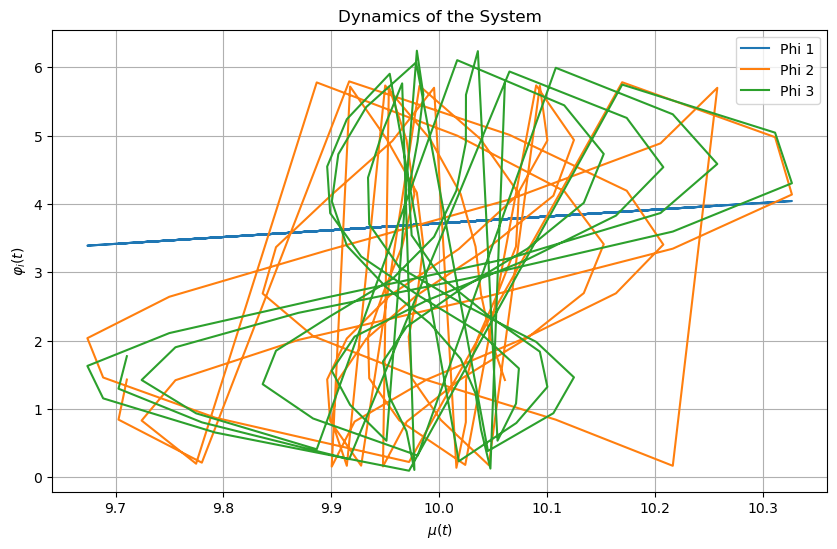

[[   9.96291123    9.95797119    9.95684042    9.94521651    9.93402497
     9.93119318    9.93943552    9.96176229   10.00453648   10.06435529
    10.11846703   10.12538954   10.07482102   10.00073983    9.93785214
     9.9078597     9.90690515    9.92365618    9.95238041    9.98691566
    10.01193282   10.01919557   10.01597822   10.01608987   10.02798385
    10.05163447   10.0776631    10.08335463   10.05473541    9.98508603
     9.89041062    9.81164963    9.77746481    9.81292438    9.93032992
    10.08678992   10.23119662   10.30405125   10.25836799   10.10828502
     9.91892386    9.75627803    9.66945763    9.67598644    9.76970004
     9.93587319   10.12705314   10.2746068    10.30878837   10.22562395
    10.07471635    9.9184997     9.80628089    9.7696968     9.80362939
     9.88784635    9.98026703   10.05253162   10.08755382   10.08826639
    10.06901989   10.04425597   10.02558363   10.01494946   10.00629858
     9.98767969    9.9570105     9.92565236    9.91012988    9.9

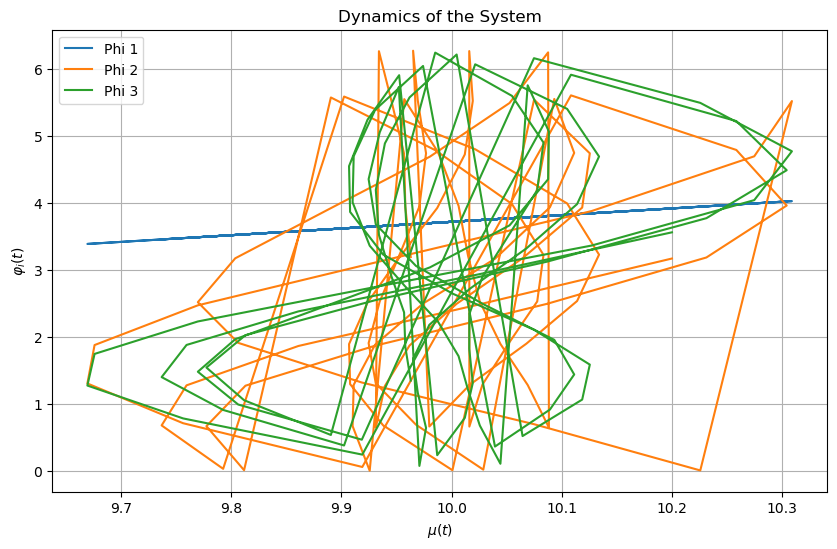

[[   9.97627667    9.99567501   10.0090331    10.01846243   10.03905323
    10.06590334   10.08647233   10.08351295   10.04292284    9.9753427
     9.91834371    9.88910177    9.88917005    9.91230565    9.95362098
    10.01315194   10.0663714    10.09268098   10.08256278   10.04098091
     9.99720129    9.9794699     9.98421036    9.99731947   10.00251028
     9.98662612    9.94342584    9.90231049    9.88130416    9.89843095
     9.96745484   10.06989304   10.16856006   10.22446649   10.20486298
    10.09161927    9.93247446    9.78396846    9.69671934    9.69587332
     9.78117831    9.94819519   10.1442443    10.30230736   10.3452313
    10.25010052   10.0684302     9.88288262    9.75111153    9.70107242
     9.74022763    9.84934088    9.99016862   10.11386382   10.185737
    10.18676429   10.13158811   10.04796544    9.96714347    9.92003811
     9.9090306     9.92396966    9.94173856    9.95083875    9.95681082
     9.96626552    9.98173991   10.00922105   10.0521888    10.09694

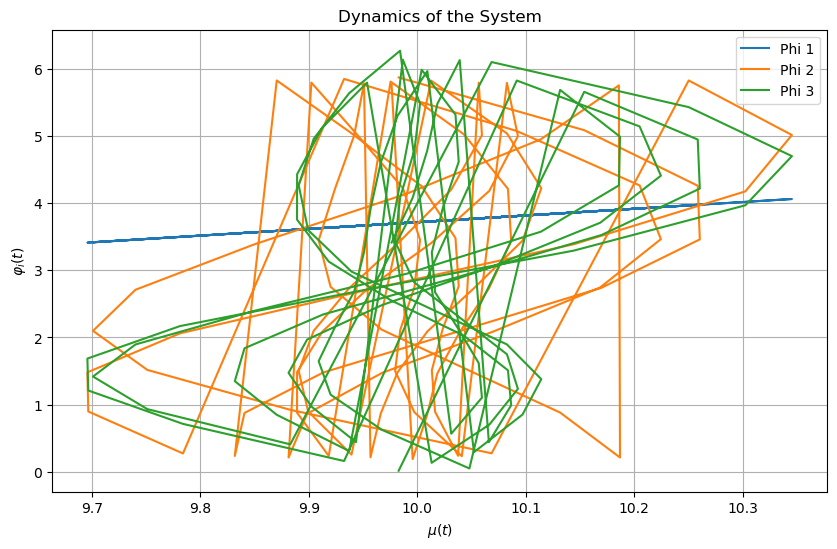

[[  10.06748721   10.05018335   10.03722295   10.02878724   10.01266266
     9.98402008    9.94449487    9.91293689    9.90341414    9.91332769
     9.94282196    9.99204501   10.05920828   10.11594505   10.12682637
    10.08374295   10.014287      9.95559853    9.93326037    9.93648673
     9.9528025     9.97120431    9.98516087    9.97859757    9.96420395
     9.95937911    9.97983024   10.02696733   10.08438597   10.13284562
    10.14630142   10.10513982   10.00432943    9.87809355    9.77226665
     9.72981678    9.77239371    9.89129943   10.06536081   10.23759302
    10.33571197   10.29666471   10.144967      9.9466522     9.77578598
     9.68411769    9.68059664    9.76445714    9.91966576   10.09321827
    10.22927751   10.2663497    10.21354492   10.09540551    9.96502591
     9.8629984     9.82836735    9.84984676    9.90447795    9.96426863
    10.00619662   10.02911484   10.0369978    10.03907322   10.04423067
    10.05733381   10.0673957    10.05914862   10.02054191    9.9

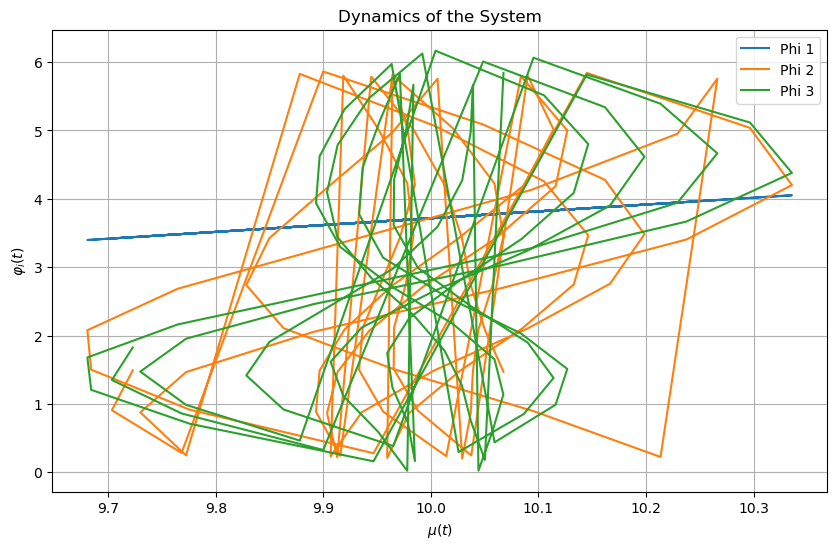

[[   9.94475141    9.94533469    9.94300911    9.93527531    9.93338988
     9.94100713    9.96083299    9.99980386   10.05321889   10.09061704
    10.10260125   10.07977441   10.01231279    9.94186606    9.90077135
     9.89260302    9.90875361    9.93863397    9.97709718   10.01291792
    10.02694363   10.02288374   10.01377364   10.01242185   10.02307861
    10.04740382   10.06696063   10.06145988   10.01659654    9.93124249
     9.84297503    9.7885551     9.80255803    9.88485866   10.02167324
    10.17322695   10.279812     10.28335515   10.17309739    9.99211525
     9.81391703    9.69469299    9.662603      9.7234247     9.8663315
    10.05675994   10.2280337    10.31549277   10.27754775   10.14168286
     9.97302188    9.83548984    9.76529267    9.77165612    9.84169154
     9.94159578   10.03194257   10.08795616   10.10374327   10.09101468
    10.06225491   10.03220582   10.01109877    9.99462214    9.97794402
     9.95691087    9.92789708    9.90886349    9.90805682    9.92

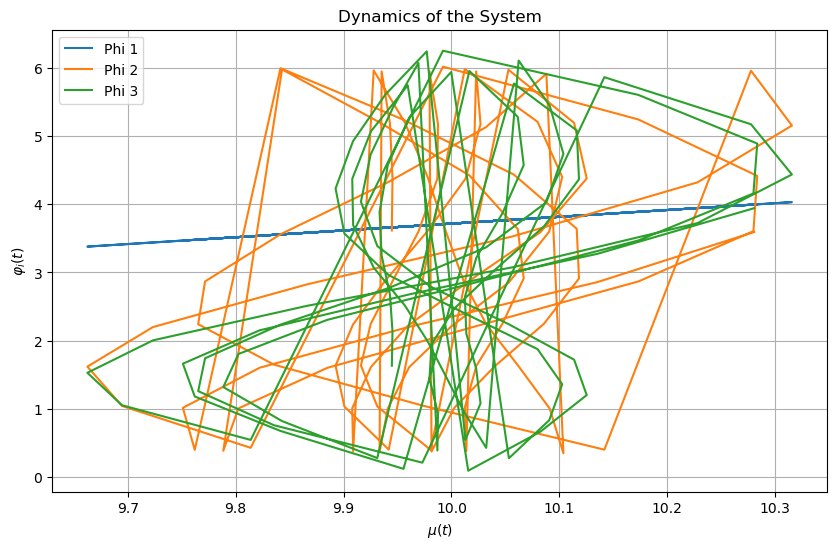

[[   9.9936217    10.01027308   10.01773752   10.02428123   10.03691426
    10.05927867   10.07425062   10.06441965   10.01912756    9.95711924
     9.90691233    9.88555698    9.89013439    9.91658837    9.96202161
    10.02418791   10.08036231   10.09995705   10.07656723   10.02899026
     9.99006694    9.97334774    9.97773642    9.98751314    9.98826498
     9.9696142     9.93285959    9.89630533    9.88717469    9.92452688
    10.00566483   10.10444511   10.18549956   10.2129741    10.16213992
    10.03619646    9.88195326    9.74812864    9.68601277    9.71562704
     9.83057066   10.01143464   10.20464891   10.32816886   10.32491731
    10.19056187    9.996853      9.82218941    9.71495224    9.6953616
     9.76073337    9.8893451    10.04014785   10.15428897   10.19847237
    10.17732085   10.10325018   10.01212339    9.9346334     9.89914673
     9.90202888    9.92671942    9.9489584     9.96091779    9.96811221
     9.97603824    9.98998009   10.01687529   10.06099143   10.09

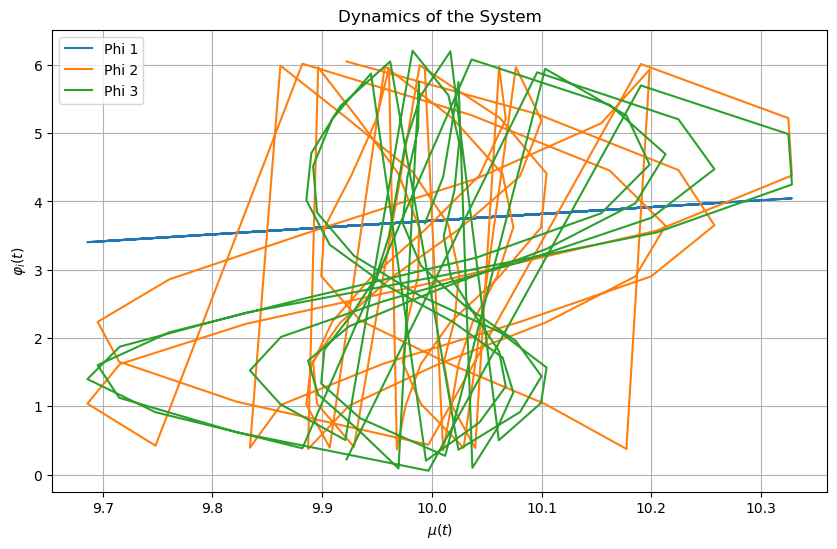

[[  10.04948855   10.02369286   10.00960858   10.00223982    9.99038168
     9.96500326    9.9340029     9.91479666    9.91165132    9.92523102
     9.95943518   10.01750323   10.08512191   10.12659126   10.11294223
    10.05281453    9.98389911    9.93877859    9.92422963    9.93051813
     9.94695705    9.96719802    9.9805375     9.97972727    9.97564361
     9.98260859   10.01352166   10.05831821   10.10464038   10.12974352
    10.10916919   10.04282274    9.93242795    9.82219854    9.75156014
     9.74997057    9.83740385    9.98777732   10.16252005   10.29741858
    10.32661005   10.22061711   10.03352603    9.84066691    9.70939102
     9.66497721    9.70997635    9.83866493   10.01618983   10.18505977
    10.27349661   10.25681061   10.15484175   10.01470557    9.8871445
     9.81869047    9.81791143    9.86584367    9.93928258   10.00066896
    10.0372901    10.04823897   10.0442121    10.03803205   10.03980024
    10.0481397    10.05145402   10.0340121     9.99366723    9.94

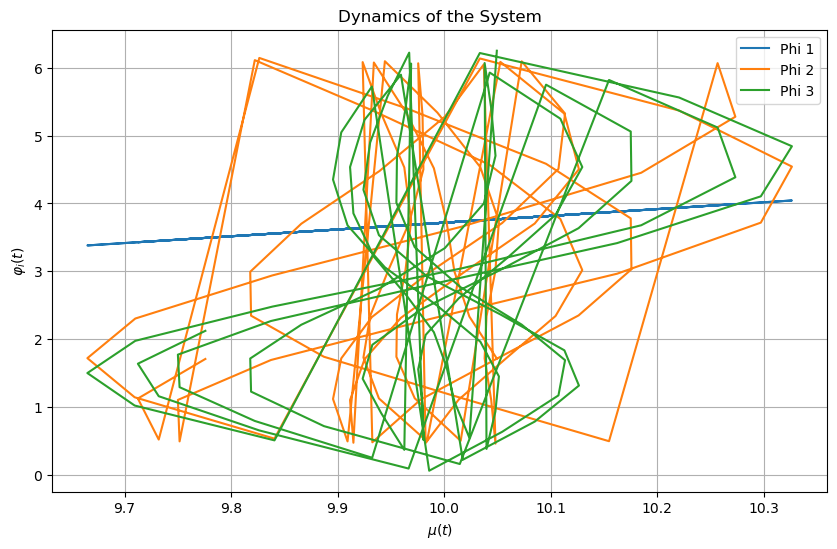

[[   9.93238817    9.94456718    9.95177306    9.95028583    9.94933119
     9.95309834    9.96763646    9.99868058   10.05112104   10.10207963
    10.11977828   10.082562     10.01058699    9.94424522    9.90625973
     9.89750345    9.9103728     9.93898952    9.98117368   10.02190741
    10.0416376    10.04052113   10.03091795   10.02648352   10.03314566
    10.04827342   10.05669979   10.04207277    9.99351377    9.91628955
     9.84214745    9.80400762    9.83176037    9.92847394   10.06753684
    10.20548757   10.2852631    10.25854508   10.12754414    9.94431595
     9.77931832    9.68059936    9.67336764    9.754851      9.91520765
    10.11230431   10.2726316    10.32792424   10.25405118   10.09642032
     9.92590066    9.79992882    9.75001423    9.77643196    9.86440166
     9.97544762   10.0704844    10.11589001   10.11641501   10.08842328
    10.0473964    10.01123905    9.9914002     9.98318362    9.97934435
     9.96247661    9.94114405    9.92612948    9.92197979    9.9

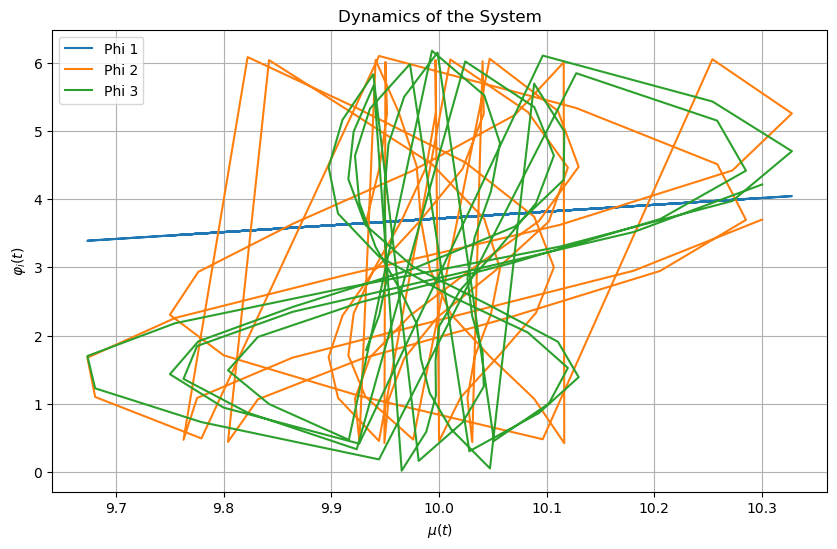

[[  10.02557116   10.02989202   10.02965033   10.0333732    10.0467447
    10.06208612   10.06176632   10.03626263    9.98408523    9.93278067
     9.9008189     9.89296565    9.90579283    9.93946587    9.99931142
    10.06467733   10.10648657   10.09902596   10.05582079   10.00732437
     9.97597292    9.96849644    9.97283687    9.97737376    9.97175537
     9.94845345    9.92059472    9.90674334    9.92319587    9.98360769
    10.071964     10.15500663   10.19932251   10.17518669   10.07468235
     9.92849079    9.79085951    9.70709867    9.70730184    9.79149265
     9.95639089   10.15174794   10.30653385   10.34476741   10.24562802
    10.05985524    9.86607417    9.73622479    9.6895287     9.72795875
     9.84355708    9.99857357   10.14212412   10.21238665   10.20509765
    10.13614112   10.03666186    9.94482123    9.88653567    9.88300238
     9.91188227    9.94806697    9.97206166    9.9825597     9.98590208
     9.99066235   10.00601048   10.03847824   10.07721751   10.09

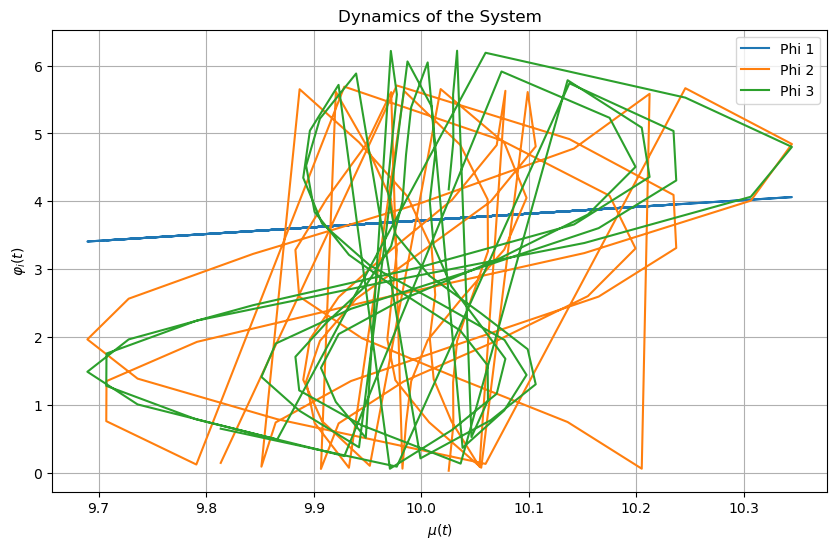

[[  10.0412719    10.01519313   10.00002189    9.98839546    9.97376802
     9.94937829    9.91968323    9.90409169    9.90488067    9.92432715
     9.96470811   10.02665715   10.09137589   10.12070032   10.09319218
    10.02485728    9.96205854    9.92276135    9.91492057    9.92464694
     9.94381689    9.96485328    9.97871472    9.97617424    9.97242912
     9.98294557   10.01314686   10.05717618   10.09987403   10.11961689
    10.09992049   10.01715287    9.90398277    9.79865779    9.74202374
     9.7606051     9.85654104   10.01754631   10.18950392   10.31125025
    10.30499004   10.18358001    9.99083561    9.80689231    9.69064803
     9.66327515    9.72453039    9.86679065   10.04809603   10.20930397
    10.27963185   10.24278061   10.12834378    9.98597602    9.86658508
     9.80751343    9.81761181    9.87398509    9.94951247   10.00806306
    10.04147088   10.04977404   10.04432751   10.03734072   10.03805085
    10.04487359   10.04460758   10.02442172    9.98109407    9.9

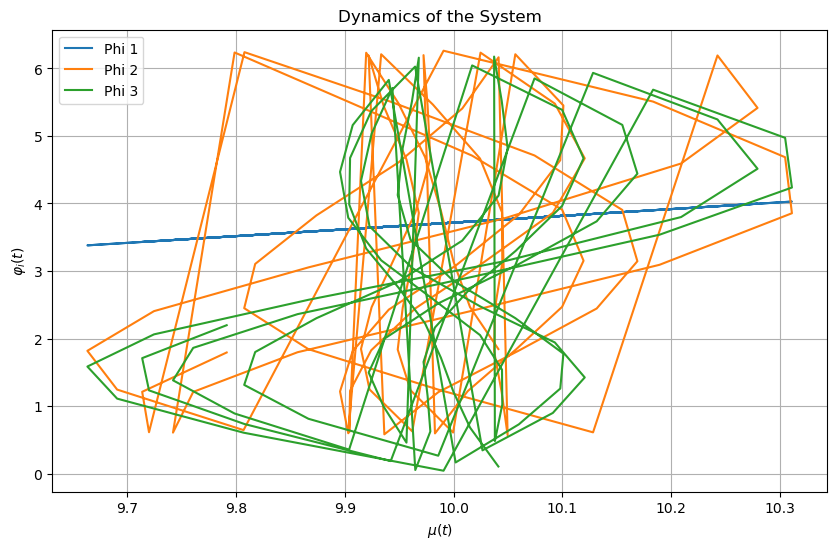

[[   9.9267434     9.94864125    9.95991863    9.96495925    9.9700632
     9.97908845   10.00388824   10.04328563   10.09174764   10.11168694
    10.09085717   10.02748506    9.95506207    9.9079625     9.892084
     9.90118272    9.92901479    9.97252861   10.02310303   10.05721824
    10.06206217   10.04550471   10.02706473   10.01862917   10.02535305
    10.03488057   10.0324495    10.0046238     9.94639327    9.87926503
     9.83338025    9.83813126    9.90814312   10.03127106   10.16313933
    10.2585718    10.26279237   10.16593591    9.99883984    9.82726609
     9.70892951    9.67442774    9.73244603    9.87419587   10.06676225
    10.2460228    10.33965354   10.29610002   10.14972386    9.96701851
     9.81441852    9.73890694    9.7459415     9.82562073    9.94545048
    10.05976383   10.13255065   10.14701845   10.11938264   10.06755304
    10.01340009    9.97192143    9.9563352     9.95551536    9.95668382
     9.94804358    9.93728601    9.9344342     9.94319864    9.9683

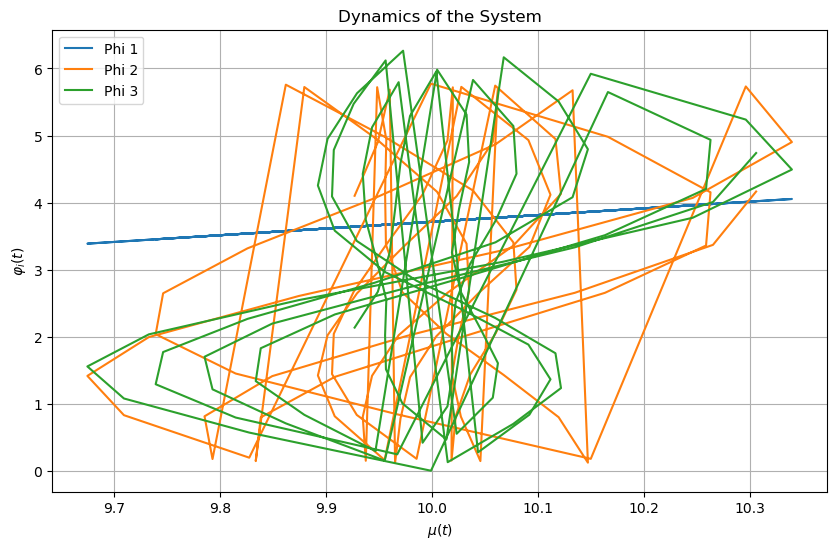

[[  10.03703175   10.03950218   10.03512935   10.03578512   10.04304131
    10.04882207   10.04448172   10.02137455    9.970322      9.92371696
     9.89806877    9.89307357    9.90840672    9.94721644   10.0114196
    10.07242949   10.10536346   10.09570252   10.04654694    9.99824008
     9.96741278    9.96133941    9.96602869    9.97061681    9.96615703
     9.94691281    9.92010165    9.90966528    9.93609054   10.00125459
    10.08594767   10.15856227   10.19033611   10.15727719   10.05159361
     9.90858724    9.77723537    9.70228233    9.71889078    9.821355
     9.98735065   10.18256269   10.31132531   10.33352039   10.21901858
    10.02594227    9.84147825    9.71816237    9.68299215    9.73679736
     9.86322539   10.023721     10.15726539   10.22528871   10.20686764
    10.12488834   10.0177652     9.9259415     9.87662622    9.87725744
     9.91261053    9.95347287    9.97984282    9.99128516    9.99116468
     9.99575203   10.01612558   10.04652273   10.08040643   10.0970

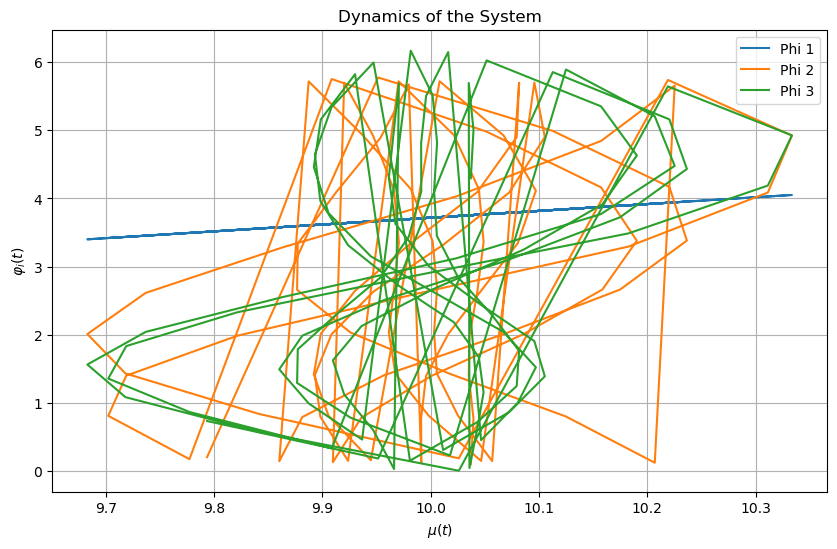

[[  10.0314323     9.99919295    9.98516552    9.97558886    9.95711004
     9.93515301    9.91946894    9.91536426    9.92746634    9.95627106
    10.00869235   10.06724511   10.10810665   10.11329829   10.06576587
     9.99028962    9.93224444    9.9084887     9.91293904    9.93227245
     9.9595324     9.98527028    9.99790694    9.99503953    9.99087297
    10.00026101   10.02767364   10.06353717   10.09663776   10.10223589
    10.06536002    9.97786251    9.87300022    9.78562854    9.75014168
     9.80170934    9.92468071   10.09030043   10.24347408   10.31519791
    10.25905487   10.0983684     9.9040396     9.74293019    9.664663
     9.67658736    9.77423071    9.94152452   10.12535099   10.26247947
    10.28751929   10.20707247   10.06569506    9.92130852    9.81904195
     9.78782884    9.821751      9.89707924    9.97425533   10.03124215
    10.05985559   10.06375233   10.05448488   10.04289757   10.03814734
    10.03477746   10.02366809    9.99317895    9.94918621    9.912

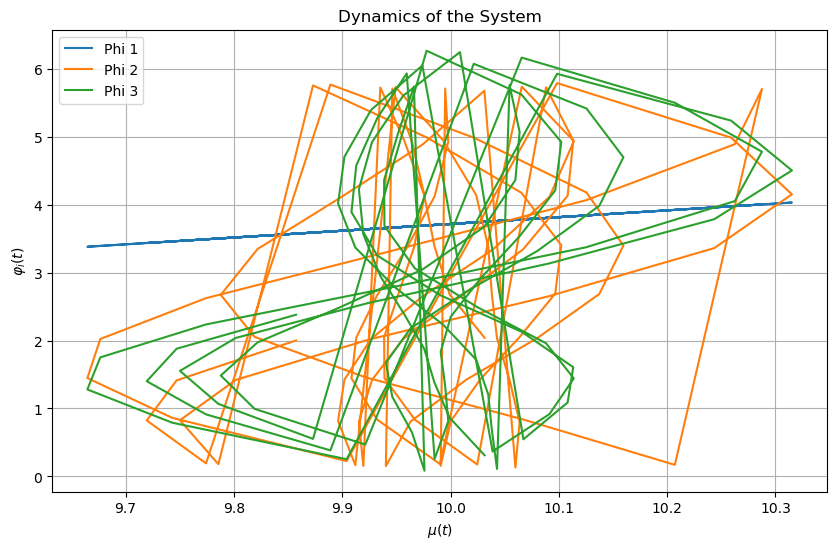

[[   9.9276348     9.94891485    9.96007374    9.96538375    9.96913302
     9.97966015   10.01078025   10.0525758    10.09594475   10.11150695
    10.08065875   10.0128058     9.94596085    9.90468657    9.89372905
     9.90504619    9.93535017    9.9816283    10.03139393   10.06211222
    10.06219116   10.04292542   10.02417971   10.01726252   10.02502355
    10.03381694   10.02869056    9.99756105    9.93627293    9.87023471
     9.83099466    9.84824764    9.93002019   10.05369844   10.18139356
    10.26213544   10.24957734   10.13706238    9.96476119    9.79945006
     9.6932433     9.67598696    9.7478424     9.90033268   10.09843079
    10.26951491   10.33940057   10.275358     10.11497713    9.93343418
     9.79623692    9.73332816    9.75347849    9.84293841    9.96567156
    10.07437189   10.13876613   10.14673208   10.11308515   10.05523533
    10.00384562    9.97327776    9.96039401    9.96184922    9.95905051
     9.94849522    9.93907511    9.93858255    9.94923943    9.9

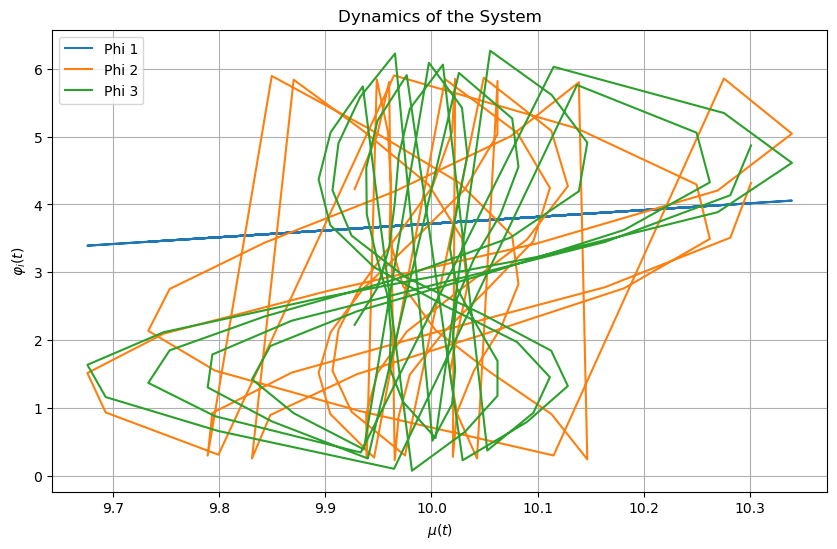

[[  10.04554297   10.04505966   10.04212799   10.0411209    10.04762478
    10.05075961   10.03865778   10.00292864    9.95277647    9.91176624
     9.89455537    9.89852452    9.92203069    9.96977429   10.03828858
    10.09678004   10.11487003   10.08260825   10.02657045    9.97855284
     9.95685797    9.95646618    9.96524955    9.97130107    9.96820505
     9.94672571    9.92441785    9.92358829    9.96059725   10.02907957
    10.10911124   10.16682224   10.17752324   10.12426101   10.00344314
     9.86549845    9.75053945    9.69974617    9.74394152    9.86889299
    10.0499062    10.23270107   10.34099537   10.30498167   10.15269588
     9.95424256    9.78426421    9.68986104    9.68583649    9.7656065
     9.91105115   10.07253008   10.19766554   10.23107851   10.18520482
    10.08874038    9.97909228    9.8953556     9.85923991    9.87540282
     9.91791708    9.95922731    9.98329784    9.99356621    9.99553248
    10.00172545   10.0248695    10.05531011   10.08209692   10.08

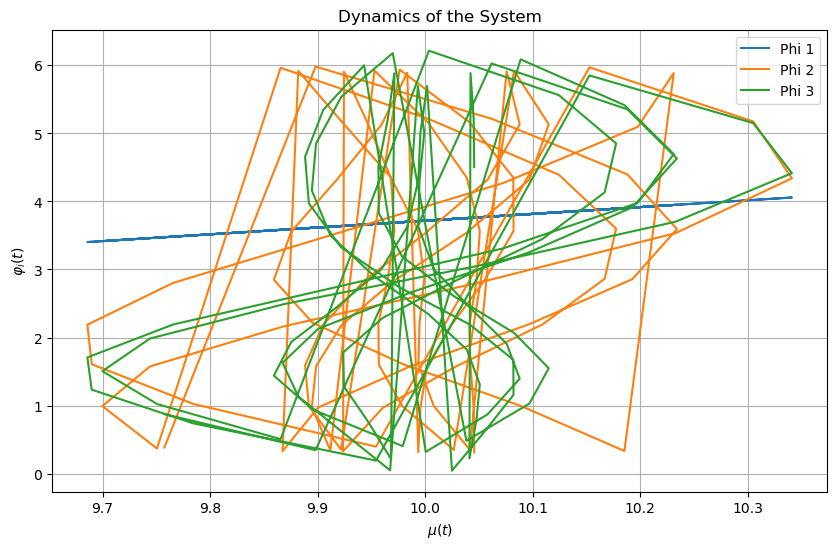

In [23]:
y0= []
for mu in mu00:
    y0 = [mu, *phi00] 
    mu1,phi = solve(y0)
    print(f'solving for y0 = {y0}')
    plot_phi_v_mu(mu1,phi)
    


In [24]:
#for i in Guesses:

#    mu,phi = solve(i)
#    plot_phi_v_mu(mu,phi)
#    print(f'{i}')

In [25]:
#basin_map = compute_basin(50,threshold,y0_range,y1_range,FP[2],epsilon)

In [26]:
#plot_basin(basin_map,epsilon,y0_range,y1_range,FP[2],threshold)

In [27]:
FP = equilibriumpoints(equations, N, omega, kappa, eta, epsilon, alpha,size)
FP

array([[0.  , 5.13, 5.01, 4.94],
       [4.01, 1.21, 0.01, 5.11]])

[[9.90937464e+00 9.89364321e+00 9.87811058e+00 ... 1.01912420e+01
  1.01901831e+01 1.01885420e+01]
 [1.38263348e+06 1.38263355e+06 1.38263362e+06 ... 1.38270243e+06
  1.38270250e+06 1.38270258e+06]
 [1.17969420e+06 1.17969425e+06 1.17969430e+06 ... 1.17975278e+06
  1.17975284e+06 1.17975290e+06]
 [9.75383213e+05 9.75383258e+05 9.75383303e+05 ... 9.75431693e+05
  9.75431755e+05 9.75431816e+05]]


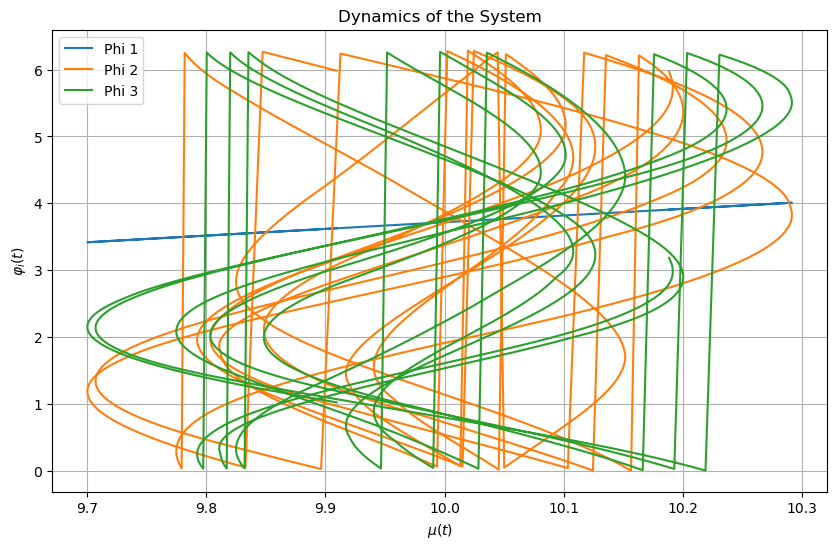

[[3.86329886e+00 3.86249489e+00 3.86170523e+00 ... 4.22178550e+00
  4.22149053e+00 4.22121228e+00]
 [1.50156691e+05 1.50156690e+05 1.50156690e+05 ... 1.50163346e+05
  1.50163348e+05 1.50163350e+05]
 [9.43451336e-02 9.20420747e-02 8.97540092e-02 ... 4.51025910e-01
  4.48890714e-01 4.46771938e-01]
 [5.28118935e+00 5.27824878e+00 5.27531600e+00 ... 5.65329726e+00
  5.65140987e+00 5.64953484e+00]]


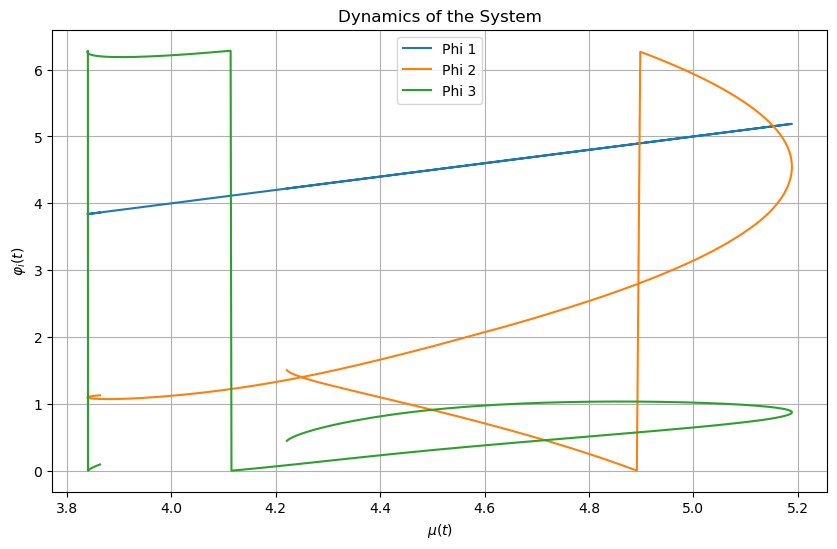

In [36]:
for i in range(len(FP)):
    y0 = FP[i]
    mu,phi = solve(y0)
    plot_phi_v_mu(mu,phi)


In [38]:
for i in range(len(FP)):
    y0 = FP[i]
    mu,phi = solve(y0)
    plot_phi_v_mu(mu,phi)


KeyboardInterrupt: 